In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

# tfds.list_builders()



2023-03-05 21:22:43.643717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset, info = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)

2023-03-05 21:22:49.245838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 21:22:49.253840: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/home/nikos/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon an

In [4]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [5]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

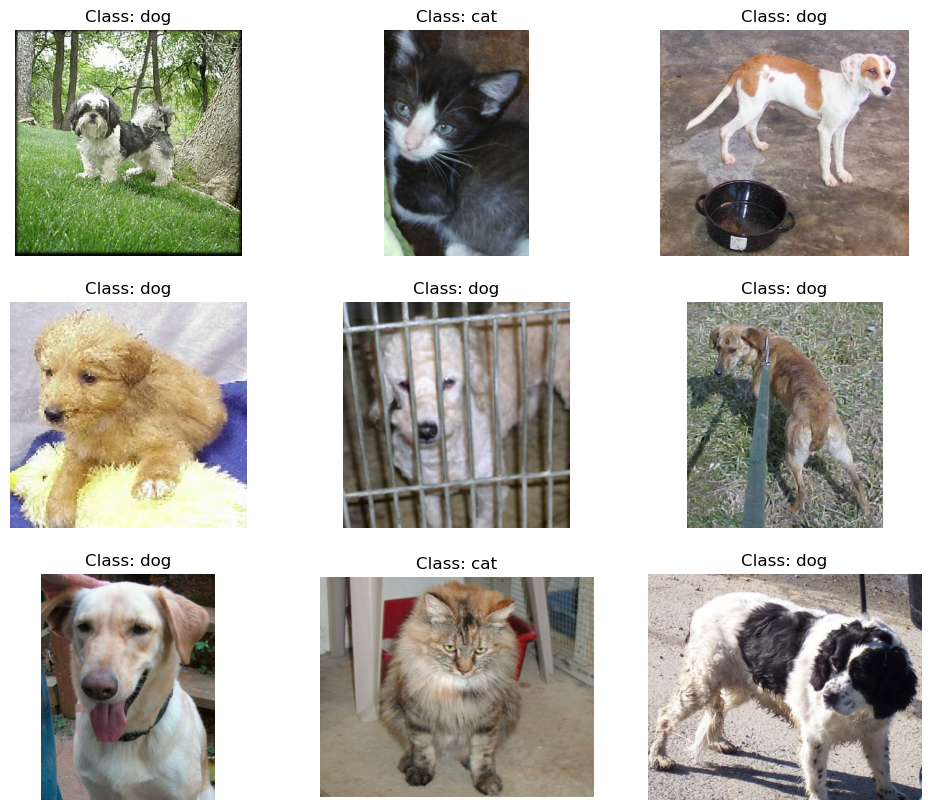

In [6]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()


In [7]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [8]:
for item in train_set_raw:
    print(item)
    break

(<tf.Tensor: shape=(350, 350, 3), dtype=uint8, numpy=
array([[[ 0,  3,  0],
        [15, 21,  7],
        [18, 24, 12],
        ...,
        [11, 11,  1],
        [10,  7,  2],
        [ 7,  4,  0]],

       [[14, 20,  6],
        [29, 35, 21],
        [33, 39, 27],
        ...,
        [11, 11,  1],
        [10,  7,  2],
        [10,  7,  2]],

       [[ 9, 15,  1],
        [19, 25, 11],
        [27, 33, 21],
        ...,
        [19, 21, 10],
        [12, 11,  6],
        [11, 10,  5]],

       ...,

       [[ 2,  7,  3],
        [ 2,  7,  1],
        [ 5, 11,  1],
        ...,
        [ 3,  8,  1],
        [ 3,  6,  0],
        [ 2,  5,  0]],

       [[ 0,  1,  0],
        [ 0,  2,  0],
        [ 0,  5,  0],
        ...,
        [ 2,  4,  0],
        [ 1,  2,  0],
        [ 0,  1,  0]],

       [[ 0,  1,  2],
        [ 0,  1,  0],
        [ 1,  4,  0],
        ...,
        [ 1,  3,  0],
        [ 1,  2,  0],
        [ 1,  2,  0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, n

In [9]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [10]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [11]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5


/home/nikos/anaconda3/envs/ml/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


133/546 [======>.......................] - ETA: 22:09 - loss: 0.1296 - accuracy: 0.9789

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 20:11 - loss: 0.1330 - accuracy: 0.9800

170/546 [========>.....................] - ETA: 19:33 - loss: 0.1335 - accuracy: 0.9803

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 17:32 - loss: 0.1436 - accuracy: 0.9803

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 15:27 - loss: 0.1380 - accuracy: 0.9816

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 14:48 - loss: 0.1342 - accuracy: 0.9818

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 8:28 - loss: 0.1196 - accuracy: 0.9841

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 4:41 - loss: 0.1178 - accuracy: 0.9845

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 4:06 - loss: 0.1169 - accuracy: 0.9845

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 3:34 - loss: 0.1171 - accuracy: 0.9845

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 2:17 - loss: 0.1150 - accuracy: 0.9848

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 1:59 - loss: 0.1164 - accuracy: 0.9847

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 1840s 3s/step - loss: 0.1117 - accuracy: 0.9852 - val_loss: 0.0749 - val_accuracy: 0.9897
Epoch 2/5
133/546 [======>.......................] - ETA: 18:40 - loss: 0.0288 - accuracy: 0.9944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 17:19 - loss: 0.0376 - accuracy: 0.9944

170/546 [========>.....................] - ETA: 16:55 - loss: 0.0377 - accuracy: 0.9939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 15:36 - loss: 0.0404 - accuracy: 0.9934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 13:58 - loss: 0.0382 - accuracy: 0.9933

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 13:24 - loss: 0.0378 - accuracy: 0.9934

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 7:55 - loss: 0.0405 - accuracy: 0.9928

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 4:26 - loss: 0.0418 - accuracy: 0.9921

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 3:53 - loss: 0.0411 - accuracy: 0.9922

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 3:23 - loss: 0.0424 - accuracy: 0.9918

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 2:10 - loss: 0.0419 - accuracy: 0.9918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 1:54 - loss: 0.0415 - accuracy: 0.9919

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 1761s 3s/step - loss: 0.0417 - accuracy: 0.9919 - val_loss: 0.0751 - val_accuracy: 0.9894
Epoch 3/5
133/546 [======>.......................] - ETA: 18:42 - loss: 0.0206 - accuracy: 0.9953

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 17:26 - loss: 0.0208 - accuracy: 0.9955

170/546 [========>.....................] - ETA: 17:00 - loss: 0.0200 - accuracy: 0.9954

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 15:28 - loss: 0.0237 - accuracy: 0.9951

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 13:58 - loss: 0.0280 - accuracy: 0.9945

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 13:29 - loss: 0.0269 - accuracy: 0.9945

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 7:57 - loss: 0.0277 - accuracy: 0.9940

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 4:27 - loss: 0.0287 - accuracy: 0.9937

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 3:54 - loss: 0.0285 - accuracy: 0.9937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 3:24 - loss: 0.0285 - accuracy: 0.9936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 2:10 - loss: 0.0284 - accuracy: 0.9937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 1:54 - loss: 0.0282 - accuracy: 0.9936

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 1768s 3s/step - loss: 0.0297 - accuracy: 0.9935 - val_loss: 0.0670 - val_accuracy: 0.9903
Epoch 4/5
133/546 [======>.......................] - ETA: 18:46 - loss: 0.0142 - accuracy: 0.9967

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 17:30 - loss: 0.0177 - accuracy: 0.9963

170/546 [========>.....................] - ETA: 17:04 - loss: 0.0174 - accuracy: 0.9963

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 15:35 - loss: 0.0184 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 14:02 - loss: 0.0221 - accuracy: 0.9953

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 13:30 - loss: 0.0211 - accuracy: 0.9955

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 7:57 - loss: 0.0216 - accuracy: 0.9953

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 4:27 - loss: 0.0232 - accuracy: 0.9948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 3:54 - loss: 0.0231 - accuracy: 0.9947

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 3:24 - loss: 0.0230 - accuracy: 0.9947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 2:10 - loss: 0.0232 - accuracy: 0.9947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 1:54 - loss: 0.0229 - accuracy: 0.9947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 1768s 3s/step - loss: 0.0236 - accuracy: 0.9947 - val_loss: 0.0652 - val_accuracy: 0.9903
Epoch 5/5
133/546 [======>.......................] - ETA: 18:26 - loss: 0.0135 - accuracy: 0.9969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 17:15 - loss: 0.0166 - accuracy: 0.9965

170/546 [========>.....................] - ETA: 16:50 - loss: 0.0157 - accuracy: 0.9967

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 15:20 - loss: 0.0173 - accuracy: 0.9963

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 13:46 - loss: 0.0168 - accuracy: 0.9959

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 13:16 - loss: 0.0166 - accuracy: 0.9959

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 7:53 - loss: 0.0188 - accuracy: 0.9954

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 4:24 - loss: 0.0203 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 3:52 - loss: 0.0200 - accuracy: 0.9950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 3:22 - loss: 0.0204 - accuracy: 0.9950

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 2:10 - loss: 0.0205 - accuracy: 0.9950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 1:53 - loss: 0.0203 - accuracy: 0.9950

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 1759s 3s/step - loss: 0.0203 - accuracy: 0.9950 - val_loss: 0.0697 - val_accuracy: 0.9885


In [14]:
for layer in base_model.layers:
    layer.trainable = True

In [15]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)

In [16]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=3, validation_data=valid_set)

Epoch 1/3
133/546 [======>.......................] - ETA: 1:09:37 - loss: 0.0967 - accuracy: 0.9688

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 1:04:50 - loss: 0.0911 - accuracy: 0.9709

170/546 [========>.....................] - ETA: 1:03:21 - loss: 0.0887 - accuracy: 0.9715

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 57:47 - loss: 0.0837 - accuracy: 0.9723

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 51:41 - loss: 0.0792 - accuracy: 0.9723

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 49:42 - loss: 0.0771 - accuracy: 0.9727

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 29:31 - loss: 0.0659 - accuracy: 0.9754

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 16:31 - loss: 0.0601 - accuracy: 0.9777

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 14:29 - loss: 0.0603 - accuracy: 0.9779

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 12:38 - loss: 0.0592 - accuracy: 0.9783

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 8:05 - loss: 0.0576 - accuracy: 0.9789

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 7:04 - loss: 0.0572 - accuracy: 0.9789

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 5804s 11s/step - loss: 0.0550 - accuracy: 0.9795 - val_loss: 0.0294 - val_accuracy: 0.9888
Epoch 2/3
133/546 [======>.......................] - ETA: 1:09:47 - loss: 0.0156 - accuracy: 0.9951

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 1:05:01 - loss: 0.0136 - accuracy: 0.9957

170/546 [========>.....................] - ETA: 1:03:29 - loss: 0.0132 - accuracy: 0.9958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 57:54 - loss: 0.0119 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 51:52 - loss: 0.0106 - accuracy: 0.9967

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 49:47 - loss: 0.0101 - accuracy: 0.9969

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 29:30 - loss: 0.0087 - accuracy: 0.9972

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 16:31 - loss: 0.0089 - accuracy: 0.9973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 14:30 - loss: 0.0090 - accuracy: 0.9972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 12:38 - loss: 0.0091 - accuracy: 0.9972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 8:06 - loss: 0.0089 - accuracy: 0.9972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 7:05 - loss: 0.0088 - accuracy: 0.9972

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 5819s 11s/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.0316 - val_accuracy: 0.9905
Epoch 3/3
133/546 [======>.......................] - ETA: 1:09:24 - loss: 0.0048 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


161/546 [=======>......................] - ETA: 1:04:42 - loss: 0.0057 - accuracy: 0.9992

170/546 [========>.....................] - ETA: 1:03:14 - loss: 0.0055 - accuracy: 0.9993

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


203/546 [==========>...................] - ETA: 57:40 - loss: 0.0049 - accuracy: 0.9994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


239/546 [============>.................] - ETA: 51:37 - loss: 0.0044 - accuracy: 0.9995

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


251/546 [============>.................] - ETA: 49:34 - loss: 0.0043 - accuracy: 0.9995

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/546 [===================>..........] - ETA: 29:27 - loss: 0.0034 - accuracy: 0.9996

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


448/546 [=======================>......] - ETA: 16:29 - loss: 0.0032 - accuracy: 0.9994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/546 [========================>.....] - ETA: 14:28 - loss: 0.0034 - accuracy: 0.9994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


471/546 [========================>.....] - ETA: 12:37 - loss: 0.0033 - accuracy: 0.9994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


498/546 [==========================>...] - ETA: 8:04 - loss: 0.0032 - accuracy: 0.9994

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


504/546 [==========================>...] - ETA: 7:04 - loss: 0.0032 - accuracy: 0.9994

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


546/546 [==============================] - 5795s 11s/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0312 - val_accuracy: 0.9914
